In [62]:
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

### Data preprocessing

In [44]:
hour_df = pd.read_csv('data/hour.csv')
print('Shape of dataset::{}'.format(hour_df.shape))

Shape of dataset::(17379, 17)


In [45]:
n = 5
hour_df.head(n) # gives us an overview of the data by showing the first n-rows

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [46]:
hour_df.dtypes # datatype of all attributes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [47]:
# clean up our columns
hour_df.rename(columns={'instant':'rec_id',
                        'dteday':'datetime',
                        'holiday':'is_holiday',
                        'workingday':'is_workingday',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_count',
                        'hr':'hour',
                        'yr':'year'},inplace=True)

In [48]:
# date time conversion
hour_df['datetime'] = pd.to_datetime(hour_df.datetime)

# categorical conversion
hour_df['season'] = hour_df.season.astype('category')
hour_df['is_holiday'] = hour_df.is_holiday.astype('category')
hour_df['weekday'] = hour_df.weekday.astype('category')
hour_df['weather_condition'] = hour_df.weather_condition.astype('category')
hour_df['is_workingday'] = hour_df.is_workingday.astype('category')
hour_df['month'] = hour_df.month.astype('category')
hour_df['year'] = hour_df.year.astype('category')
hour_df['hour'] = hour_df.hour.astype('category')

### Distribution and Trends

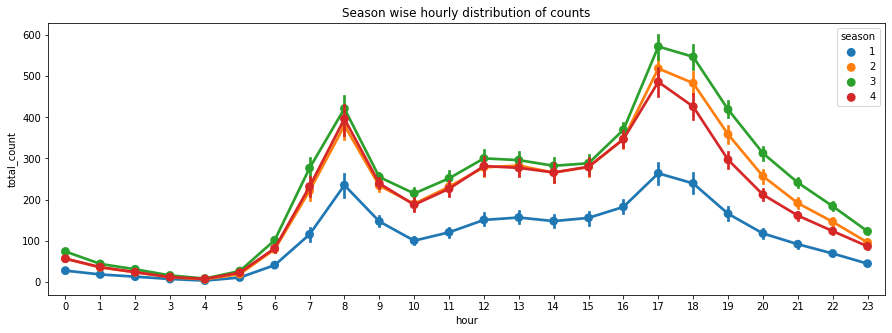

In [49]:
## summary per season, per hour
fig, ax = plt.subplots(figsize=(15, 5))
sns.pointplot(data=hour_df[['season', 'hour', 'total_count']], x='hour', y='total_count', hue='season', ax=ax)
ax.set(title='Season wise hourly distribution of counts')
plt.show()

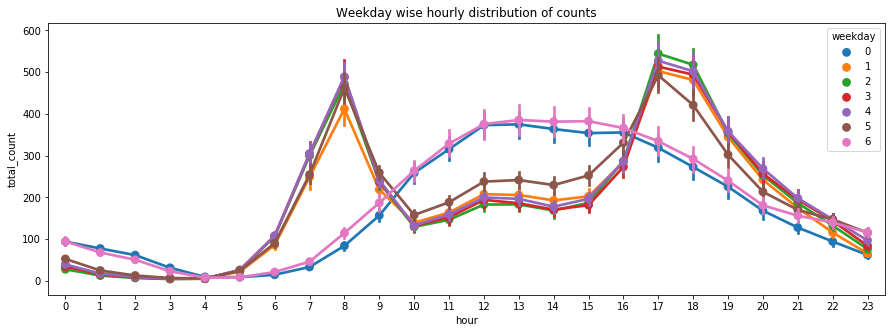

In [50]:
## summary per day of the week, per hour
fig, ax = plt.subplots(figsize=(15, 5))
sns.pointplot(data=hour_df[['weekday', 'hour', 'total_count']], x='hour', y='total_count', hue='weekday', ax=ax)
ax.set(title='Weekday wise hourly distribution of counts')
plt.show()

[Text(0.5, 1.0, 'Monthly distribution of counts')]

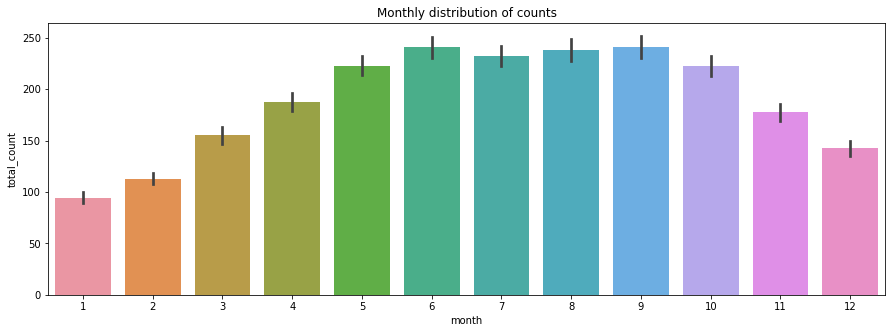

In [51]:
# total usage per month
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=hour_df[['month', 'total_count']], x='month', y='total_count')
ax.set(title='Monthly distribution of counts')

[Text(0.5, 1.0, 'Monthly distribution of counts')]

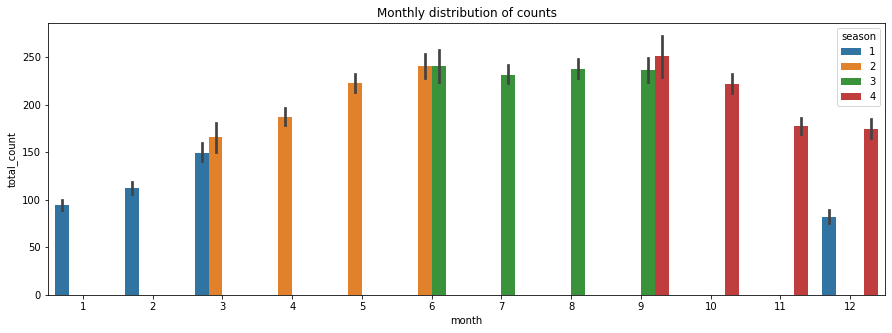

In [52]:
# per season per month
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=hour_df[['season', 'month', 'total_count']], x='month', y='total_count', hue='season', ax=ax)
ax.set(title='Monthly distribution of counts')

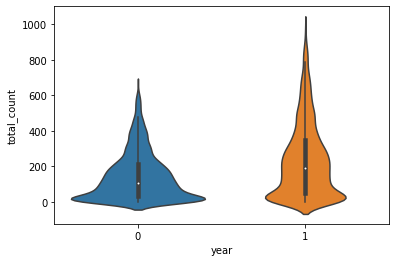

In [53]:
# distribution per year
sns.violinplot(data=hour_df[['year', 'total_count']], x='year', y='total_count')

### Outliers

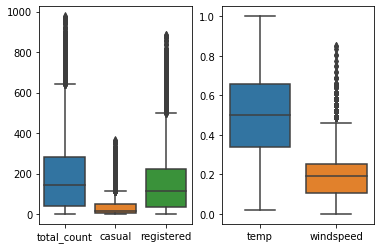

In [54]:
fig, (ax1,ax2)= plt.subplots(ncols=2)
sns.boxplot(data=hour_df[['total_count','casual','registered']],ax=ax1)
sns.boxplot(data=hour_df[['temp','windspeed']],ax=ax2)

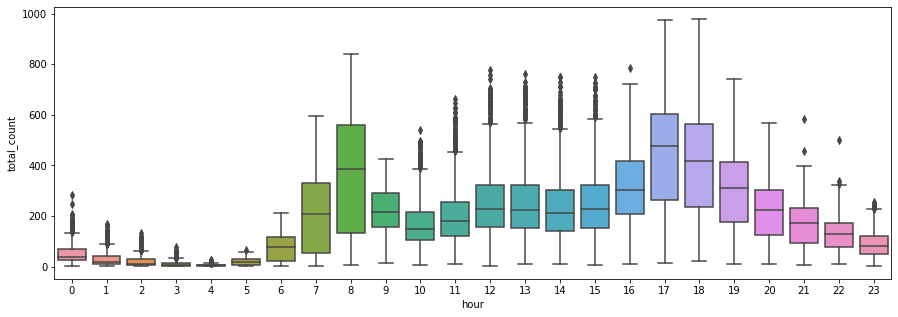

In [55]:
# outliers per hour
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=hour_df[['hour', 'total_count']], x='hour', y='total_count')

### Correlation

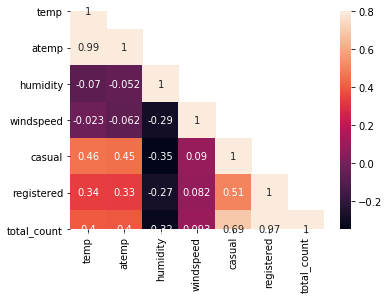

In [56]:
corrMatt = hour_df[["temp","atemp",
                    "humidity","windspeed",
                    "casual","registered",
                    "total_count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=True,annot=True)

## Modelling 

In [61]:
def fit_transform_ohe(df, col_name):
    le = LabelEncoder()
    le_labels = le.fit_transform(df[col_name])
    df[col_name + '_label'] = le_labels
    
    ohe = OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return le,ohe,features_df

### Train Test split

In [64]:
X, x_test, y, y_test = train_test_split(hour_df.iloc[:,0:-3],
                                        hour_df.iloc[:,-1],
                                        test_size=0.33,
                                        random_state=42)
X.reset_index(inplace=True)
y = y.reset_index()

x_test.reset_index(inplace=True)
y_test = y_test.reset_index()

In [65]:
cat_attr_list = ['season','is_holiday',
                 'weather_condition','is_workingday',
                 'hour','weekday','month','year']
encoded_attr_list = []
for col in cat_attr_list:
    return_obj = fit_transform_ohe(X,col)
    encoded_attr_list.append({'label_enc':return_obj[0],
                              'ohe_enc':return_obj[1],
                              'feature_df':return_obj[2],
                              'col_name':col})

D:\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
D:\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneH

In [66]:
feature_df_list = [X[numeric_feature_cols]]
feature_df_list.extend([enc['feature_df'] \
                        for enc in encoded_attr_list \
                        if enc['col_name'] in subset_cat_features])
train_df_new = pd.concat(feature_df_list, axis=1)
print("Shape::{}".format(train_df_new.shape))

NameError: name 'numeric_feature_cols' is not defined